# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from txt_feat import get_features
from sklearn.cluster import KMeans
from utils import get_disease_class
from lstm import KTokenizer, get_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TRAINF_PATH = 'pos_neg.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
TESTF_PATH = 'test_pos_neg.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
pd.read_csv(TRAIN_PATH).head()

,ID,Код_диагноза,Диагноз,Возраст,Пол,Общее состояние,аллергия,Анамнез заболевания,Внешний осмотр,Revisit
0,0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [5]:
df = initial_pre(pd.concat([pd.read_csv(TRAIN_PATH), pd.read_csv(TRAINF_PATH, index_col=0)], axis=1))
len(df)

283086

In [6]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit,pos,neg,pos_w,neg_w
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1,0.0,0.0,0.0,0.0
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1,0.0,0.0,0.0,0.0
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1,0.0,0.0,0.0,0.0
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1,0.0,0.0,0.0,0.0
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1,0.0,0.0,0.0,0.0


In [7]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit,pos,neg,pos_w,neg_w
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000,283086.000000,283086.000000,283086.000000,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN,NaN,NaN,NaN,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN,NaN,NaN,NaN,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639,0.143695,0.011767,0.049013,-0.004810
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825,0.393101,0.109234,0.135304,0.044713
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.869863
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df.dtypes

diag_code     object
diag          object
age            int64
sex            int64
state         object
allergies     object
anamnesis     object
checkup       object
revisit        int64
pos          float64
neg          float64
pos_w        float64
neg_w        float64
dtype: object

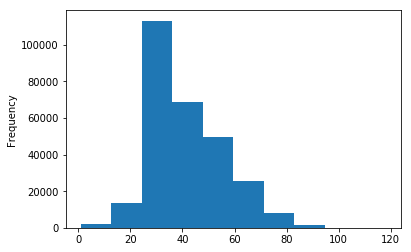

In [9]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

### Look up

In [10]:
tdf = initial_pre(pd.concat([pd.read_csv(TEST_PATH), pd.read_csv(TESTF_PATH, index_col=0)], axis=1))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,pos,neg,pos_w,neg_w
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN,0.0,0.0,0.0,0.0
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN,0.0,0.0,0.0,0.0
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...,0.0,0.0,0.0,0.0
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN,0.0,0.0,0.0,0.0


In [11]:
tdf.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,pos,neg,pos_w,neg_w
count,100000,100000,100000.000000,100000.000000,27475,36484,39282,10710,100000.000000,100000.000000,100000.000000,100000.000000
unique,2750,2718,NaN,NaN,2337,4790,31786,744,NaN,NaN,NaN,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN,NaN,NaN,NaN
freq,4618,4618,NaN,NaN,5807,15593,540,5382,NaN,NaN,NaN,NaN
mean,NaN,NaN,42.581630,1.663910,NaN,NaN,NaN,NaN,0.083690,0.007140,0.026702,-0.002649
std,NaN,NaN,32.847483,0.472372,NaN,NaN,NaN,NaN,0.304182,0.084906,0.097972,0.031554
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,-0.801064
25%,NaN,NaN,32.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,39.000000,2.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [12]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [13]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

### Not in `tdf`

In [14]:
def filter_not_in_test(df, tdf, column):
    df = df.copy()
    in_tdf = set(tdf.loc[:, column])
    return df[df.loc[:, column].isin(in_tdf)].copy()

In [15]:
for column in tqdm_notebook(df.columns):
    if column not in {'revisit', 'anamnesis'}:
        df = filter_not_in_test(df, tdf, column)
        print('after', column, df.shape)
df.shape

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

after diag_code (280470, 13)
after diag (280470, 13)
after age (280456, 13)
after sex (280456, 13)
after state (278242, 13)
after allergies (274857, 13)
after checkup (274572, 13)
after pos (274572, 13)
after neg (274572, 13)
after pos_w (238145, 13)
after neg_w (235532, 13)



(235532, 13)

### Strings fuzzy matching

In [16]:
def group_column(df, tdf, column):
    df, tdf = df.copy(), tdf.copy()
    columnv = pd.concat([df[column], tdf[column]])
    cvc = columnv.value_counts()
    bins = []
    for s, c in tqdm_notebook(cvc.iteritems()):
        max_id, max_score = None, None
        for id_, bin_ in enumerate(bins):
            cur_score = fuzz.ratio(s, bin_[0])
            if max_score is None or cur_score > max_score:
                max_id = id_
                max_score = cur_score
        if max_id is not None and max_score > 75:
            bins[max_id].append(s)
        else:
            bins.append([s])
    remap_dict = {}
    for bin_ in bins:
        base = bin_[0]
        for v in bin_:
            remap_dict[v] = base
    df[column] = df[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    tdf[column] = tdf[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    return df, tdf

In [17]:
SIMILAR_TEXT_COLUMNS = ['state', 'allergies', 'checkup']
for column in tqdm_notebook(SIMILAR_TEXT_COLUMNS):
    df, tdf = group_column(df, tdf, column)
df.shape, tdf.shape

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

((235532, 13), (100000, 12))

## Preprocess

In [18]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode

In [19]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._encs = None
    
    def fit(self, df):
        return self
    
    def transform(self, df, tdf=None):
        df = df.copy()
    
        features = []
        
        # `diag_code`
        def to_str(x):
            if x is None:
                return ''
            else:
                return str(x)
        
        def pparse(x):
            l, c, s = x
            c = to_str(l) + to_str(c)
            if not c:
                c = None
            return (l, c)
        
        parts = list(df.diag_code \
                     .apply(parse_diag_code) \
                     .apply(pparse))
        features.append(pd.DataFrame(parts, 
                                     columns=['letter', 'code', 'subcode'][:2],
                                     dtype=object, index=df.index))

        # `age`
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
#         df.age = df.age.astype(str)  # => To cat
        features.append(df[['age']])

        # `sex`
        features.append(df[['sex']])

        # `state`
        def state_map(s):
            if 'удовлетворительн' in str(s).lower():
                return True
            else:
                return False
            
        features.append(pd.DataFrame(df.state.apply(state_map).astype(int),
                                     columns=['state'],
                                     index=df.index, dtype=int))
        
        # `diag`, `allergies`, `checkup`
        features.append(df[['allergies', 'checkup']])
        
        
        # anamnesis
        features.append(get_features(df.anamnesis, df.index))
        features.append(pd.DataFrame(df.anamnesis.isnull().as_matrix().astype(int), 
                                     columns=['anamnesis_null'],
                                     index=df.index))
        
        # sentiment features
        features.append(df[['pos', 'neg', 'pos_w', 'neg_w']])

        data = pd.concat(features, axis=1)
        
        # object => int
#         data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        objs = data.dtypes[data.dtypes == object].index.tolist()
        if self._encs is None:
            self._encs = [LabelEncoder().fit(pd.concat([data[obj].fillna('NaN'), 
                                                        pd.Series('NaN')], axis=0)) for obj in objs]
        for obj, enc in zip(objs, self._encs):
            data.loc[~data[obj].isin(enc.classes_), obj] = np.nan
            data[obj] = enc.transform(data[obj].fillna('NaN'))
        
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [20]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,age,sex,state,allergies,checkup,count_nums,exclamation,larger_than_three,not_stop_words,number_words,punct,stop_words,string_len,anamnesis_null,pos,neg,pos_w,neg_w
0,9,315,29.0,2,0,82,94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,13,532,45.0,2,0,82,59,0.0,0.0,30.0,30.0,42.0,4.0,12.0,302.0,0,0.0,0.0,0.0,0.0
2,11,374,63.0,2,0,82,59,1.0,0.0,10.0,11.0,14.0,5.0,3.0,99.0,0,0.0,0.0,0.0,0.0
3,13,517,43.0,2,0,1100,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,23,716,29.0,1,0,82,59,0.0,0.0,5.0,5.0,6.0,0.0,1.0,52.0,0,0.0,0.0,0.0,0.0


In [21]:
X.dtypes

letter                 int64
code                   int64
age                  float64
sex                    int64
state                  int64
allergies              int64
checkup                int64
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
pos                  float64
neg                  float64
pos_w                float64
neg_w                float64
dtype: object

In [22]:
y.dtype

dtype('int64')

## TT split

In [23]:
def downsampling(X, y):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    sampled_ids1 = y[y == 1].sample(len(ids0)).index
    nX = pd.concat([X.loc[ids0], X.loc[sampled_ids1]], axis=0)
    ny = pd.concat([y[ids0], y[sampled_ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny


def upsampling(X, y, max_cnt=10000):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    n = min(len(ids1), max_cnt)
    sampled_ids0 = y[y == 0].sample(n, replace=True).index
    index = np.arange(y.index.max() + 1, y.index.max() + n + 1)
    nX = X.loc[sampled_ids0]
    nX.index = index
    nX = pd.concat([nX, X.loc[ids1]], axis=0)
    ny = pd.concat([pd.Series(y[sampled_ids0].as_matrix(), index=index), y[ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny

In [24]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
# X_train, y_train = upsampling(X_train, y_train)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((223755, 20), (11777, 20), (100000, 20))

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

### Run

In [25]:
N_MODELS = 5

In [26]:
models = [cb.CatBoostClassifier(depth=8, eval_metric='AUC', random_seed=42,
                                iterations=2000, od_type='Iter', od_wait=300) 
          for _ in range(N_MODELS)]

In [27]:
def get_stack_score(X):
    return np.vstack((model.predict_proba(X)[:, 1] for model in models)).mean(axis=0)


def get_f_im():
    return np.vstack((model.feature_importances_ for model in models)).mean(axis=0)

In [ ]:
X.dtypes

letter                 int64
code                   int64
age                  float64
sex                    int64
state                  int64
allergies              int64
checkup                int64
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
pos                  float64
neg                  float64
pos_w                float64
neg_w                float64
dtype: object

In [ ]:
for i, model in enumerate(models):
    print(f'ITERATION NUMBER {i}')
    X_train, X_val, y_train, y_val = train_test_split(*downsampling(X, y), test_size=0.1)
    model.fit(X_train, y_train, cat_features=cat_features, 
              use_best_model=True, eval_set=(X_val, y_val), 
              plot=False);

ITERATION NUMBER 0
0:	learn: 0.7015314	test: 0.6953023	best: 0.6953023 (0)	total: 223ms	remaining: 7m 26s
1:	learn: 0.7018400	test: 0.6956926	best: 0.6956926 (1)	total: 414ms	remaining: 6m 53s
2:	learn: 0.7018609	test: 0.6955200	best: 0.6956926 (1)	total: 558ms	remaining: 6m 11s
3:	learn: 0.7027189	test: 0.6966827	best: 0.6966827 (3)	total: 680ms	remaining: 5m 39s
4:	learn: 0.7026131	test: 0.6966195	best: 0.6966827 (3)	total: 774ms	remaining: 5m 8s
5:	learn: 0.7030901	test: 0.6970059	best: 0.6970059 (5)	total: 868ms	remaining: 4m 48s
6:	learn: 0.7032785	test: 0.6971208	best: 0.6971208 (6)	total: 969ms	remaining: 4m 35s
7:	learn: 0.7033018	test: 0.6971002	best: 0.6971208 (6)	total: 1.08s	remaining: 4m 30s
8:	learn: 0.7035900	test: 0.6971669	best: 0.6971669 (8)	total: 1.22s	remaining: 4m 30s
9:	learn: 0.7039767	test: 0.6976766	best: 0.6976766 (9)	total: 1.36s	remaining: 4m 30s
10:	learn: 0.7041487	test: 0.6976488	best: 0.6976766 (9)	total: 1.51s	remaining: 4m 33s
11:	learn: 0.7042678	tes

94:	learn: 0.7218125	test: 0.7112106	best: 0.7112106 (94)	total: 12.3s	remaining: 4m 7s
95:	learn: 0.7219440	test: 0.7112867	best: 0.7112867 (95)	total: 12.5s	remaining: 4m 7s
96:	learn: 0.7220581	test: 0.7113518	best: 0.7113518 (96)	total: 12.6s	remaining: 4m 8s
97:	learn: 0.7221532	test: 0.7114349	best: 0.7114349 (97)	total: 12.7s	remaining: 4m 7s
98:	learn: 0.7223189	test: 0.7115272	best: 0.7115272 (98)	total: 12.8s	remaining: 4m 6s
99:	learn: 0.7224207	test: 0.7114647	best: 0.7115272 (98)	total: 13s	remaining: 4m 6s
100:	learn: 0.7224533	test: 0.7114758	best: 0.7115272 (98)	total: 13.1s	remaining: 4m 6s
101:	learn: 0.7225268	test: 0.7115318	best: 0.7115318 (101)	total: 13.2s	remaining: 4m 6s
102:	learn: 0.7226617	test: 0.7115900	best: 0.7115900 (102)	total: 13.4s	remaining: 4m 6s
103:	learn: 0.7229035	test: 0.7115690	best: 0.7115900 (102)	total: 13.6s	remaining: 4m 7s
104:	learn: 0.7229652	test: 0.7116085	best: 0.7116085 (104)	total: 13.7s	remaining: 4m 7s
105:	learn: 0.7230018	tes

187:	learn: 0.7313649	test: 0.7128362	best: 0.7129945 (154)	total: 25s	remaining: 4m 1s
188:	learn: 0.7314366	test: 0.7128873	best: 0.7129945 (154)	total: 25.1s	remaining: 4m
189:	learn: 0.7314878	test: 0.7128837	best: 0.7129945 (154)	total: 25.3s	remaining: 4m
190:	learn: 0.7315128	test: 0.7128964	best: 0.7129945 (154)	total: 25.4s	remaining: 4m
191:	learn: 0.7315776	test: 0.7129110	best: 0.7129945 (154)	total: 25.6s	remaining: 4m 1s
192:	learn: 0.7316138	test: 0.7129096	best: 0.7129945 (154)	total: 25.8s	remaining: 4m 1s
193:	learn: 0.7317700	test: 0.7129175	best: 0.7129945 (154)	total: 25.9s	remaining: 4m 1s
194:	learn: 0.7319484	test: 0.7129279	best: 0.7129945 (154)	total: 26s	remaining: 4m
195:	learn: 0.7320570	test: 0.7129712	best: 0.7129945 (154)	total: 26.1s	remaining: 4m
196:	learn: 0.7321299	test: 0.7129733	best: 0.7129945 (154)	total: 26.2s	remaining: 4m
197:	learn: 0.7322239	test: 0.7129972	best: 0.7129972 (197)	total: 26.4s	remaining: 4m
198:	learn: 0.7322821	test: 0.71300

In [ ]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X, y, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_test, y_test), 
#           plot=False);

In [ ]:
# pool = cb.Pool(X, y, cat_features=cat_features)
# params = {
#     'depth': 8, 
#     'eval_metric': 'AUC'
# }
# cb.cv(pool, params, seed=42)

In [ ]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', rsm=.5)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

### Analysis

In [ ]:
# # roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
# roc_auc_score(y_val, get_stack_score(X_val))

In [ ]:
# confusion_matrix(y_val, model.predict(X_val))

In [ ]:
# model.get_params()

In [ ]:
# def draw_importance(columns, importances, top_k=20, save_path=None):
#     order = np.argsort(importances)[-top_k:]
    
#     objects = columns[order]
#     y_pos = np.arange(len(objects))
#     performance = np.array(importances)[order]

#     plt.figure(figsize=(20, 10))
#     plt.barh(y_pos, performance, align='center', alpha=0.5)
#     plt.yticks(y_pos, objects)
#     plt.xlabel('Importance')
#     plt.title('Feature')

#     if save_path:
#         plt.savefig(save_path)
#     plt.show()

In [ ]:
# # draw_importance(X_train.columns, model.feature_importances_, save_path=None)
# draw_importance(X_train.columns, get_f_im(), save_path=None)

In [ ]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = get_stack_score(X_test)
# sdf.head()

## LIGHTGBM

In [ ]:
# import lightgbm as lgb

In [ ]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [ ]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': ['binary_logloss', 'auc'],
#     'num_leaves': 31,
#     'learning_rate': 0.02,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0,
#     'depth': 8,
#     'subsample': 0.7
# }

# model = lgb.train(params,
#                   lgb_train,
#                   num_boost_round=50,
#                   valid_sets=lgb_eval,
#                   early_stopping_rounds=50)

In [ ]:
# model.feature_importance()

In [ ]:
# def draw_importance(columns, importances, top_k=20, save_path=None):
#     order = np.argsort(importances)[-top_k:]
    
#     objects = columns[order]
#     y_pos = np.arange(len(objects))
#     performance = np.array(importances)[order]

#     plt.figure(figsize=(20, 10))
#     plt.barh(y_pos, performance, align='center', alpha=0.5)
#     plt.yticks(y_pos, objects)
#     plt.xlabel('Importance')
#     plt.title('Feature')

#     if save_path:
#         plt.savefig(save_path)
#     plt.show()

In [ ]:
# draw_importance(X_train.columns, model.feature_importance(), save_path=None)

In [ ]:
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
# from sklearn.linear_model import LogisticRegression

## Submission

In [ ]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict(X_test)
sdf.head()

In [ ]:
sdf.to_csv(SUBMISSION_PATH, index=False)

## BT_ITER

In [ ]:
# N_ITERS = 2

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [ ]:
# np.where((y_prob1 >= .95) | (y_prob1 <= .05))[0].shape

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [ ]:
# np.where(y_prob1 <= .5)[0].shape

In [ ]:
# np.where(y_prob1 >= .95)[0].shape

In [ ]:
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1
# vtdf = vtdf.loc[t0i | t1i]
# vtdf.head()

In [ ]:
# confusion_matrix(y_val, model.predict(X_val))

In [ ]:
# (y_val == 0).sum() / len(y_val)

In [ ]:
# vdf = df.copy()

# # TT split
# preprocess = FFTransformer()
# X, y = preprocess.fit_transform(vdf)
# cat_features = np.where(X.dtypes != np.float)[0]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
# X_test = preprocess.transform(tdf)

# # Train
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

# # BT
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1


# # Submission
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = y_prob1
# sdf.to_csv(SUBMISSION_PATH, index=False)

In [ ]:
# s1 = pd.read_csv('submission.csv').proba
# s2 = pd.read_csv('10_8_stack080_020.csv').proba

In [ ]:
# from scipy.stats import pearsonr

In [ ]:
# pearsonr(s1, s2)

In [ ]:
# sdf.head()

In [ ]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = (s1 + s2) / 2
# sdf.to_csv(SUBMISSION_PATH, index=False)